In [1]:
from SimPEG import Mesh, Directives, Maps, InvProblem, Optimization, DataMisfit, Inversion, Utils, Regularization, mkvc
import SimPEG.PF as PF
import numpy as np
from scipy import sparse as sp
import SimPEG.PF as PF
from SimPEG.Utils import mkvc
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# # STEP 1: Setup and data simulation # #
    
# Magnetic inducing field parameter (A,I,D)
B = [50000, 90, 0]

# Create a mesh
dx = 5.

hxind = [(dx, 5, -1.3), (dx, 15), (dx, 5, 1.3)]
hyind = [(dx, 5, -1.3), (dx, 15), (dx, 5, 1.3)]
hzind = [(dx, 5, -1.3), (dx, 7)]

mesh = Mesh.TensorMesh([hxind, hyind, hzind], 'CC0')
mesh.x0[2] -= mesh.vectorNz[-1]

# Get index of the center
midx = int(mesh.nCx/2)
midy = int(mesh.nCy/2)
midz = int(mesh.nCz/2)

# Lets create a simple flat topo and set the active cells
[xx, yy] = np.meshgrid(mesh.vectorNx, mesh.vectorNy)
zz = np.ones_like(xx)*mesh.vectorNz[-1]
topo = np.c_[Utils.mkvc(xx), Utils.mkvc(yy), Utils.mkvc(zz)]

# Go from topo to actv cells
actv = Utils.surface2ind_topo(mesh, topo, 'N')
actv = np.asarray([inds for inds, elem in enumerate(actv, 1) if elem],
                  dtype=int) - 1

# Create active map to go from reduce space to full
actvMap = Maps.InjectActiveCells(mesh, actv, -100)
nC = int(len(actv))

# We can now create a susceptibility model and generate data
# Here a simple block in half-space
# blk_X = [-9+ midx,midx,9+ midx]
# blk_Z = [-4, -4, -4]
# blk_A = [0.05, 0.05, 0.05]
# blk_I = [-90, 0, 0]
# blk_D = [0, 0, 90]
blk_X = [midx]
blk_Z = [-4]
blk_A = [0.05]
blk_I = [-45]
blk_D = [215]

mA = np.zeros((mesh.nCx, mesh.nCy, mesh.nCz))
mI = np.zeros((mesh.nCx, mesh.nCy, mesh.nCz))
mD = np.zeros((mesh.nCx, mesh.nCy, mesh.nCz))

for ii in range(len(blk_X)):
    mA[(blk_X[ii]-1):(blk_X[ii]+2), (midy-1):(midy+2), (blk_Z[ii]-1):(blk_Z[ii]+2)] = blk_A[ii]
    mI[(blk_X[ii]-1):(blk_X[ii]+2), (midy-1):(midy+2), (blk_Z[ii]-1):(blk_Z[ii]+2)] = blk_I[ii]
    mD[(blk_X[ii]-1):(blk_X[ii]+2), (midy-1):(midy+2), (blk_Z[ii]-1):(blk_Z[ii]+2)] = blk_D[ii]
    

mA = Utils.mkvc(mA)
mA = mA[actv]

# We create a magnetization model different than the inducing field
# to simulate remanent magnetization. Let's do something simple,
# reversely magnetized [45,90]
M = Utils.matutils.dipazm_2_xyz(mkvc(mI)[actv], mkvc(mD)[actv])

# Multiply the orientation with the effective susceptibility
# and reshape as [mx,my,mz] vector
m = mkvc(sp.diags(mA, 0) * M)


In [3]:
def plotModelSections(mesh, m, normal='x', ind=0, vmin=None, vmax=None,
                      subFact=2, scale=1., xlim=None, ylim=None, vec='k',
                      title=None, axs=None, actv=None, contours=None, fill=True,
                      orientation='vertical', cmap='pink_r'):

    """
    Plot section through a 3D tensor model
    """
    # plot recovered model
    nC = mesh.nC

    if vmin is None:
        vmin = m[np.isnan(m)!=True].min()

    if vmax is None:
        vmax = m[np.isnan(m)!=True].max()

    if len(m) == 3*nC:
        m_lpx = m[0:nC]
        m_lpy = m[nC:2*nC]
        m_lpz = m[2*nC:]

        if actv is not None:
            m_lpx[actv!=True] = np.nan
            m_lpy[actv!=True] = np.nan
            m_lpz[actv!=True] = np.nan

        amp = np.sqrt(m_lpx**2. + m_lpy**2. + m_lpz**2.)

        m_lpx = (m_lpx).reshape(mesh.vnC, order='F')
        m_lpy = (m_lpy).reshape(mesh.vnC, order='F')
        m_lpz = (m_lpz).reshape(mesh.vnC, order='F')
        amp = amp.reshape(mesh.vnC, order='F')
    else:

        if actv is not None:
            m[actv!=True] = np.nan

        amp = m.reshape(mesh.vnC, order='F')

    xx = mesh.gridCC[:, 0].reshape(mesh.vnC, order="F")
    zz = mesh.gridCC[:, 2].reshape(mesh.vnC, order="F")
    yy = mesh.gridCC[:, 1].reshape(mesh.vnC, order="F")

    if axs is None:
        fig, axs = plt.figure(), plt.subplot()

    if normal == 'x':
        xx = yy[ind, :, :].T
        yy = zz[ind, :, :].T
        model = amp[ind, :, :].T

        if len(m) == 3*nC:
            mx = m_lpy[ind, ::subFact, ::subFact].T
            my = m_lpz[ind, ::subFact, ::subFact].T

    elif normal == 'y':
        xx = xx[:, ind, :].T
        yy = zz[:, ind, :].T
        model = amp[:, ind, :].T

        if len(m) == 3*nC:
            mx = m_lpx[::subFact, ind, ::subFact].T
            my = m_lpz[::subFact, ind, ::subFact].T

    elif normal == 'z':

        if actv is not None:
            actIndFull = np.zeros(mesh.nC, dtype=bool)
            actIndFull[actv] = True
        else:
            actIndFull = np.ones(mesh.nC, dtype=bool)

        actIndFull = actIndFull.reshape(mesh.vnC, order='F')

        model = np.zeros((mesh.nCx, mesh.nCy))
        mx = np.zeros((mesh.nCx, mesh.nCy))
        my = np.zeros((mesh.nCx, mesh.nCy))
        for ii in range(mesh.nCx):
            for jj in range(mesh.nCy):

                zcol = actIndFull[ii, jj, :]
                model[ii, jj] = amp[ii, jj, np.where(zcol)[0][-ind]]

                if len(m) == 3*nC:
                    mx[ii, jj] = m_lpx[ii, jj, np.where(zcol)[0][-ind]]
                    my[ii, jj] = m_lpy[ii, jj, np.where(zcol)[0][-ind]]

        xx = xx[:, :, ind].T
        yy = yy[:, :, ind].T
        model = model.T

        if len(m) == 3*nC:
            mx = mx[::subFact, ::subFact].T
            my = my[::subFact, ::subFact].T

    im2, cbar = [], []
    if fill:
        im2 = axs.contourf(xx, yy, model,
                           30, vmin=vmin, vmax=vmax,
                           cmap=cmap)

        cbar = plt.colorbar(im2, orientation=orientation, ax=axs,
                 ticks=np.linspace(vmin, vmax, 4),
                 format="${%.3f}$", shrink=0.5)
    if contours is not None:
        axs.contour(xx, yy, model, contours, colors='k')

    if len(m) == 3*nC:

        axs.quiver(mkvc(xx[::subFact, ::subFact]),
                   mkvc(yy[::subFact, ::subFact]),
                   mkvc(mx),
                   mkvc(my),
                   pivot='mid',
                   scale_units="inches", scale=scale, linewidths=(1,),
                   edgecolors=(vec),
                   headaxislength=0.1, headwidth=10, headlength=30)

    axs.set_aspect('equal')

    if xlim is not None:
        axs.set_xlim(xlim[0], xlim[1])

    if ylim is not None:
        axs.set_ylim(ylim[0], ylim[1])

    if title is not None:
        axs.set_title(title)

    return axs, im2, cbar

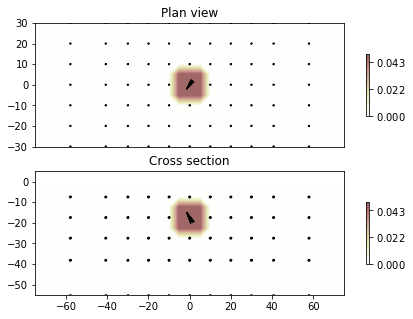

In [5]:
# plot true model
plt.figure(figsize(8, 5))
ax3 = plt.subplot(211)
#PF.Magnetics.plotModelSections
plotModelSections(
    mesh, m, normal='z', ind=midz-1, subFact=2, 
    scale=0.25, xlim=[-75, 75], ylim=[-30, 30],
    title='Plan view', axs=ax3, vmin=0, vmax=0.065)
#im,CS = Utils.PlotUtils.plotModelSections(mesh, m, normal='z', ind=-3, subFact=2, scale=0.25, xlim=[-75, 75], ylim=[-30, 30],title="True Model", axs=ax3, vmin=0, vmax=0.065)
ax3.xaxis.set_visible(False)

ax2 = plt.subplot(212)
#PF.Magnetics.plotModelSections
sc = plotModelSections(
    mesh, m, normal='y', ind=midy, subFact=2, 
    scale=0.25, xlim=[-75, 75], ylim=[-55, 5], 
    axs=ax2, vmin=0, vmax=0.065,
    title='Cross section')
#im,CS = Utils.PlotUtils.plotModelSections(mesh, m, normal='y', ind=midy, subFact=2, scale=0.25, xlim=[-75, 75], ylim=[-55, 5],axs=ax2, vmin=0, vmax=0.065)

In [9]:
sc[1]

In [5]:
# Create and array of observation points
xr = np.linspace(-75., 75., 20)
yr = np.linspace(-25., 25., 20)
X, Y = np.meshgrid(xr, yr)

# Move the observation points 5m above the topo
Z = np.ones_like(X) * mesh.vectorNz[-1] + dx

# Create a MAGsurvey
rxLoc = np.c_[Utils.mkvc(X.T), Utils.mkvc(Y.T), Utils.mkvc(Z.T)]
rxObj = PF.BaseMag.RxObs(rxLoc)
srcField = PF.BaseMag.SrcField([rxObj], param=(B[0], B[1], B[2]))
survey = PF.BaseMag.LinearSurvey(srcField)

In [6]:
# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actv, -100)

# Create reduced identity map
idenMap = Maps.IdentityMap(nP=3*nC)

# Create the forward model operator
prob = PF.Magnetics.MagneticIntegral(mesh, chiMap=idenMap, modelType='vector',
                                   actInd=actv, parallelized=True)

# Pair the survey and problem
survey.pair(prob)

# Compute forward model some data
d = prob.fields(m)

# Add noise and uncertainties
# We add some random Gaussian noise (1nT)
d_TMI = d + np.random.randn(len(d))*0.
wd = np.ones(len(d_TMI))  # Assign flat uncertainties
survey.dobs = d_TMI
survey.std = wd


Begin forward: M=full, Rx type= tmi


Text(0.5, 1.0, 'Noisy Data')

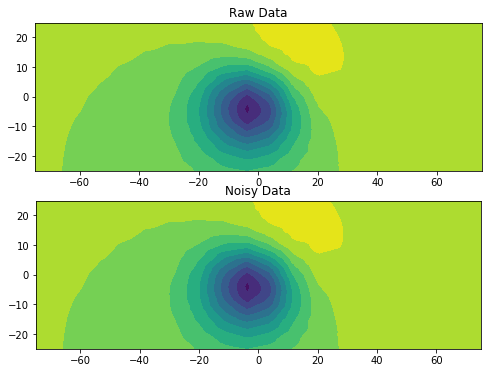

In [8]:
# Plot the data
fig = plt.figure(figsize=(8, 6))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
out = Utils.plot2Ddata(rxLoc, d, ax=ax1)
ax1.set_title('Raw Data')
out = Utils.plot2Ddata(rxLoc, d_TMI, ax=ax2)
ax2.set_title('Noisy Data')


# Susceptibility Inversion

Assumption is wrong in this case since the magnetization is pointing in a different direction than the inducing field

In [9]:
# For comparison, let's run the inversion assuming an induced response
Mind = Utils.matutils.dipazm_2_xyz(np.ones(nC) * B[1], np.ones(nC) * B[2])

# Create a simple mag problem
# Create reduced identity map
idenMap = Maps.IdentityMap(nP=nC)
prob = PF.Magnetics.MagneticIntegral(mesh, chiMap=idenMap, actInd=actv, parallelized=True)

if survey.ispaired:
    survey.unpair()
survey.pair(prob)

# Create a regularization function, in this case l2l2
wr = np.sum(prob.G**2., axis=0)**0.5
wr = (wr/np.max(wr))

# Create a regularization
reg_Susc = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
reg_Susc.cell_weights = wr

# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1./wd

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=20, lower=0., upper=1.,
                                 maxIterLS=20, maxIterCG=10, tolCG=1e-3)
invProb = InvProblem.BaseInvProblem(dmis, reg_Susc, opt)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, minGNiter=1)
update_Jacobi = Directives.UpdatePreconditioner()
inv = Inversion.BaseInversion(invProb,
                              directiveList=[IRLS, betaest, update_Jacobi])

# Run the inversion
m0 = np.ones(nC)*1e-4  # Starting model
mrec_Susc = inv.run(m0)

Begin forward: M=H0, Rx type= tmi
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  9.79e+09  7.49e+04  0.00e+00  7.49e+04    5.98e+01      0              
   1  4.89e+09  6.82e+04  2.89e-07  6.96e+04    6.06e+01      0              
   2  2.45e+09  6.64e+04  5.59e-07  6.78e+04    6.13e+01      0   Skip BFGS  
   3  1.22e+09  6.43e+04  1.20e-06  6.58e+04    6.18e+01      0   Skip BFGS  
   4  6.12e+08  6.10e+04  3.20e-06  6.30e+04    6.22e+01      0   Skip BFGS  
   5  3.06e+08  5.58e+04  9.55e-06  5.87e+04    6.29e+01      0   Skip BFGS  
   6  1.53e+08  4.82e+04  2.78e-05  5.24e+04    6.37e

C:\Users\DominiqueFournier\Documents\GIT\SimPEG\SimPEG\Directives.py:921: RuntimeWarning: divide by zero encountered in double_scalars
  self.f_change = np.abs(self.f_old - phim_new) / self.f_old


Beta search step
  17  1.31e+05  1.78e+02  2.90e-03  5.57e+02    5.97e+01      0              
Beta search step
  17  2.13e+05  1.78e+02  2.90e-03  7.96e+02    5.83e+01      0   Skip BFGS  
Beta search step
  17  2.97e+05  1.78e+02  2.90e-03  1.04e+03    5.66e+01      0   Skip BFGS  
Beta search step
  17  3.62e+05  1.78e+02  2.90e-03  1.23e+03    5.50e+01      0              
Beta search step
  17  4.05e+05  1.78e+02  2.90e-03  1.35e+03    5.30e+01      0              
delta phim: 6.392e-02
  18  4.05e+05  1.90e+02  2.81e-03  1.33e+03    5.37e+01      0              
Beta search step
  18  4.61e+05  1.90e+02  2.81e-03  1.49e+03    5.28e+01      0              
delta phim: 4.572e-02
  19  4.61e+05  2.03e+02  2.76e-03  1.48e+03    5.31e+01      0              
delta phim: 4.080e-02
  20  4.61e+05  1.94e+02  2.77e-03  1.47e+03    5.35e+01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 4.9245e+00 <= tolF*(1+|f0|) = 7.4883e+03
1 : |xc-x_last|

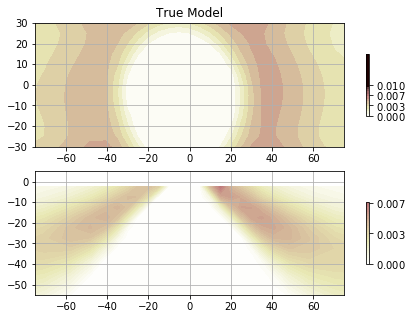

In [10]:
plt.figure(figsize(8, 5))
ax3 = plt.subplot(211)
#PF.Magnetics.plotModelSections
plotModelSections(mesh, mrec_Susc, normal='z', ind=midz-1, subFact=2, scale=0.25, xlim=[-75, 75], ylim=[-30, 30],
                      title='True Model', axs=ax3, vmin=0, vmax=0.01)
#im,CS = Utils.PlotUtils.plotModelSections(mesh, m, normal='z', ind=-3, subFact=2, scale=0.25, xlim=[-75, 75], ylim=[-30, 30],title="True Model", axs=ax3, vmin=0, vmax=0.065)
# ax3.xaxis.set_visible(False)
ax3.grid(True)

ax2 = plt.subplot(212)
#PF.Magnetics.plotModelSections
plotModelSections(mesh, mrec_Susc, normal='y', ind=midy, subFact=2, scale=0.25, xlim=[-75, 75], ylim=[-55, 5], axs=ax2, vmin=0, vmax=0.01)
ax2.grid(True)
#im,CS = Utils.PlotUtils.plotModelSections(mesh, m, normal='y', ind=midy, subFact=2, scale=0.25, xlim=[-75, 75], ylim=[-55, 5],axs=ax2, vmin=0, vmax=0.065)

# EQUIVALENT SOURCE INVERSION

Will use the equivalent source to forward model amplitude data

In [11]:
# %% STEP 1: EQUIVALENT SOURCE LAYER
# The first step inverts for an equiavlent source layer in order to convert the
# observed TMI data to magnetic field Amplitude.

# Get the active cells for equivalent source is the top only
surf = PF.MagneticsDriver.actIndFull2layer(mesh, actv)

# Get the layer of cells directyl below topo
#surf = Utils.actIndFull2layer(mesh, active)
nC = len(surf)  # Number of active cells

# Create active map to go from reduce set to full
surfMap = Maps.InjectActiveCells(mesh, surf, -100)

# Create identity map
idenMap = Maps.IdentityMap(nP=nC)

# Create static map
prob = PF.Magnetics.MagneticIntegral(mesh, chiMap = idenMap, actInd=surf, parallelized = True, equiSourceLayer = True)
prob.solverOpts['accuracyTol'] = 1e-4

# Pair the survey and problem
if survey.ispaired:
    survey.unpair()
survey.pair(prob)


# Create a regularization function, in this case l2l2
reg = Regularization.Sparse(mesh, indActive=surf, mapping=Maps.IdentityMap(nP=nC), scaledIRLS=False)
reg.mref = np.zeros(nC)

# Specify how the optimization will proceed, set susceptibility bounds to inf
opt = Optimization.ProjectedGNCG(maxIter=20, lower=-np.inf,
                                 upper=np.inf, maxIterLS=20,
                                 maxIterCG=20, tolCG=1e-3)

# Define misfit function (obs-calc)
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1./survey.std

# Create the default L2 inverse problem from the above objects
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)

# Specify how the initial beta is found
betaest = Directives.BetaEstimate_ByEig()

# Target misfit to stop the inversion,
# try to fit as much as possible of the signal, we don't want to lose anything
IRLS = Directives.Update_IRLS(f_min_change=1e-3, minGNiter=1,
                              beta_tol = 1e-1)
update_Jacobi = Directives.UpdatePreconditioner()
# Put all the parts together
inv = Inversion.BaseInversion(invProb,
                              directiveList=[betaest, IRLS, update_Jacobi])

# Run the equivalent source inversion
mstart = np.ones(nC)*1e-4
mrec = inv.run(mstart)

#%% STEP 2: COMPUTE AMPLITUDE DATA
# Now that we have an equialent source layer, we can forward model alh three
# components of the field and add them up: |B| = ( Bx**2 + Bx**2 + Bx**2 )**0.5

# Won't store the sensitivity and output 'xyz' data.
prob.forwardOnly=True
prob.rxType='xyz'
prob.modelType = 'amplitude'
prob.model = mrec
pred = prob.fields(mrec)

ndata = survey.nD

damp = np.sqrt(pred[:ndata]**2. +
                       pred[ndata:2*ndata]**2. +
                       pred[2*ndata:]**2.)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
Begin forward: M=H0, Rx type= tmi
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.22e+10  7.72e+04  3.13e-06  1.15e+05    3.40e+07      0              
   1  6.08e+09  6.78e+04  1.26e-07  6.86e+04    3.29e+06      0              
   2  3.04e+09  6.50e+04  4.79e-07  6.64e+04    3.20e+06      0   Skip BFGS  
   3  1.52e+09  5.98e+04  1.73e-06  6.25e+04    3.05e+06      0   Skip BFGS  
   4  7.60e+08  5.15e+04  5.78e-06  5.59e+04    2.80e+06      0   Skip BFGS  
   5  3.80e+08  3.99e+04  1.69e-05  4.63e+04    2.41e+06      0   Skip BFGS  
   6  1.90e+08  2.68e+04  4.19e-05  3.47e+04    1.91e+06      0   Skip BFGS  
   7  9.50e+07  1.52e+04  8.5

Text(0.5, 1.0, 'Amplitude Data')

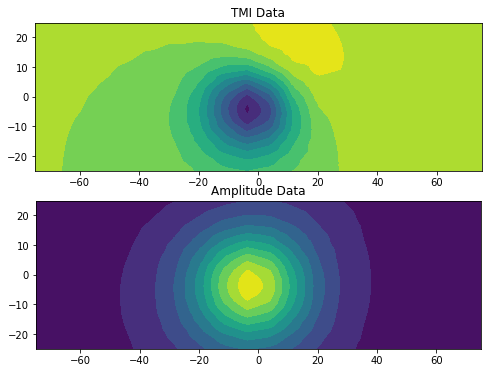

In [12]:
# Plot the TMI and amplitude data
fig = plt.figure(figsize=(8, 6))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
out = Utils.plot2Ddata(rxLoc, d_TMI, ax=ax1)
ax1.set_title('TMI Data')

out = Utils.plot2Ddata(rxLoc, damp, ax=ax2)
ax2.set_title('Amplitude Data')


# AMPLITUDE INVERSION

In [13]:
#%% STEP 3: RUN AMPLITUDE INVERSION
# Now that we have |B| data, we can invert. This is a non-linear inversion,
# which requires some special care for the sensitivity weights (see Directives)

# Create active map to go from reduce space to full
actvMap = Maps.InjectActiveCells(mesh, actv, -100)
nC = len(actv)

# Create identity map
idenMap = Maps.IdentityMap(nP=nC)

mstart= np.ones(len(actv))*1e-4

# Create the forward model operator
prob = PF.Magnetics.MagneticIntegral(mesh, chiMap=idenMap,
                                     actInd=actv, modelType='amplitude',
                                    rxType='xyz')
prob.model = mstart
# Change the survey to xyz components
survey_xyz = PF.BaseMag.LinearSurvey(srcField)
survey_xyz.srcField.rxList[0].rxType = 'xyz'

# Pair the survey and problem
survey_xyz.pair(prob)
# Create a regularization function, in this case l2l2
# wr = np.sum(prob.G**2., axis=0)**0.5
# wr = (wr/np.max(wr))
# Re-set the observations to |B|
survey_xyz.dobs = damp

# Create a regularization function, in this case l2l2

# Create a regularization function, in this case l2l2
# wr = np.sum(prob.F**2., axis=0)**0.5
# wr = (wr/np.max(wr))

# Create a sparse regularization
reg = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
# reg.norms= np.c_[1,0,0,0]
reg.mref = np.zeros(nC)
# reg.cell_weights= wr
# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey_xyz)
dmis.W = 1/survey.std

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=10, lower=0., upper=1.,
                                 maxIterLS=20, maxIterCG=20,
                                 tolCG=1e-3)

invProb = InvProblem.BaseInvProblem(dmis, reg, opt)

# Here is the list of directives
betaest = Directives.BetaEstimate_ByEig()

# Specify the sparse norms
IRLS = Directives.Update_IRLS(f_min_change=1e-3,
                              minGNiter=3, coolingRate=1)

# Special directive specific to the mag amplitude problem. The sensitivity
# weights are update between each iteration.
update_SensWeight = Directives.UpdateSensitivityWeights(everyIter=True)
update_Jacobi = Directives.UpdatePreconditioner(epsilon=1e-3)

# Put all together
inv = Inversion.BaseInversion(invProb,
                                   directiveList=[betaest, IRLS, update_SensWeight, update_Jacobi,])

# Invert
mrec_Amp = inv.run(mstart)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
Begin forward: M=H0, Rx type= xyz
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.68e+08  1.16e+05  1.75e-06  1.16e+05    6.63e+01      0              
   1  2.34e+08  2.64e+04  7.96e-05  4.51e+04    5.59e+01      0              
   2  1.17e+08  1.99e+04  9.33e-05  3.08e+04    5.92e+01      0   Skip BFGS  
   3  5.86e+07  9.14e+03  1.15e-04  1.59e+04    5.72e+01      0              
   4  2.93e+07  2.78e+03  1.85e-04  8.19e+03    5.80e+01      0   Skip BFGS  
   5  1.46e+07  1.08e+03  2.11e-04  4.17e+03    5.68e+01      0   Skip BFGS  
   6  7.32e+06  3.24e+02  2.53e-

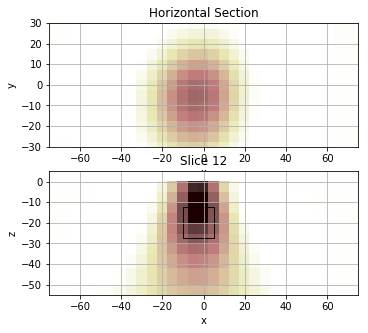

In [14]:
from matplotlib.patches import Rectangle

plt.figure(figsize(8, 5))
ax3 = plt.subplot(211)
#PF.Magnetics.plotModelSections
mesh.plotSlice(invProb.model, normal='Z', ind=midz-1,ax=ax3,clim=[0, 0.005], pcolorOpts={"cmap":'pink_r'})
ax3.set_aspect('equal')
ax3.set_xlim([-75, 75])
ax3.set_ylim([-30, 30])
ax3.set_title('Horizontal Section')
ax3.grid(True)

ax2 = plt.subplot(212)
#PF.Magnetics.plotModelSections
mesh.plotSlice(invProb.model, normal='Y', ind=midy,ax=ax2,clim=[0, 0.005], pcolorOpts={"cmap":'pink_r'})
ax2.set_aspect('equal')
ax2.set_xlim([-75, 75])
ax2.set_ylim([-55, 5])
ax2.grid(True)
ax2.add_patch(Rectangle((mesh.vectorCCx[midx]-2*dx,mesh.vectorCCz[midz]),3*dx, 3*dx, facecolor = 'none', edgecolor='k'))


Text(0.5, 1.0, 'Pred Data')

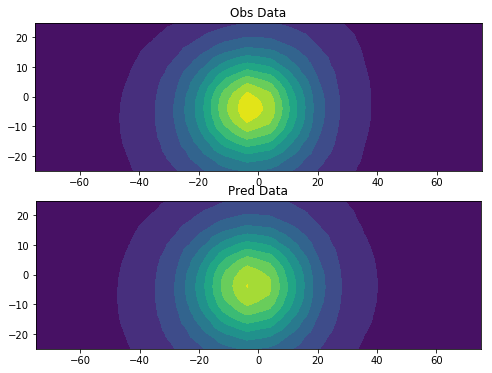

In [15]:
fig = plt.figure(figsize=(8, 6))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
out = Utils.plot2Ddata(rxLoc, damp, ax=ax1)
ax1.set_title('Obs Data')
out = Utils.plot2Ddata(rxLoc,invProb.dpred, ax=ax2)
                         
ax2.set_title('Pred Data')

# Magnetic Vector Inversion - Cartesian

In [16]:
# # STEP 2: Invert for a magnetization model in Cartesian space # #
# Create the forward model operator
idenMap = Maps.IdentityMap(nP=3*nC)
prob = PF.Magnetics.MagneticIntegral(mesh, chiMap=idenMap,
                                     actInd=actv, parallelized=True,
                                  modelType='vector')
nC = len(actv)
# Explicitely set starting model

# Pair the survey and problem
survey = PF.BaseMag.LinearSurvey(srcField)
survey.dobs = d_TMI
survey.std = wd

survey.pair(prob)

# Create a static sensitivity weighting function
wr = np.sum(prob.G**2., axis=0)**0.5
wr = (wr/np.max(wr))

# Create a block diagonal regularization
wires = Maps.Wires(('p', nC), ('s', nC), ('t', nC))

# Create a regularization
reg_p = Regularization.Sparse(mesh, indActive=actv, mapping=wires.p)
reg_p.cell_weights = (wires.p * wr)
reg_p.norms = np.c_[2, 2, 2, 2]
reg_p.mref = np.zeros(3*nC)

reg_s = Regularization.Sparse(mesh, indActive=actv, mapping=wires.s)
reg_s.cell_weights = (wires.s * wr)
reg_s.norms = np.c_[2, 2, 2, 2]
reg_s.mref = np.zeros(3*nC)

reg_t = Regularization.Sparse(mesh, indActive=actv, mapping=wires.t)
reg_t.cell_weights = (wires.t * wr)
reg_t.norms = np.c_[2, 2, 2, 2]
reg_t.mref = np.zeros(3*nC)

reg = reg_p + reg_s + reg_t
reg.mref = np.zeros(3*nC)


# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1./survey.std

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=10, lower=-10., upper=10.,
                                 maxIterCG=20, tolCG=1e-3)

invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
IRLS = Directives.Update_IRLS(f_min_change=1e-4,
                              minGNiter=1, beta_tol=5e-1)

update_Jacobi = Directives.UpdatePreconditioner()

inv = Inversion.BaseInversion(invProb,
                              directiveList=[IRLS, update_Jacobi, betaest])

mstart = np.ones(3*nC)*1e-4
mrec_C = inv.run(mstart)
beta = invProb.beta

Begin forward: M=full, Rx type= tmi
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.36e+09  6.86e+04  4.28e-06  8.73e+04    1.50e+03      0              
   1  2.18e+09  4.77e+04  4.11e-06  5.67e+04    1.50e+03      0              
   2  1.09e+09  3.29e+04  6.36e-06  3.99e+04    1.50e+03      0   Skip BFGS  
   3  5.45e+08  2.14e+04  1.39e-05  2.90e+04    1.50e+03      0   Skip BFGS  
   4  2.73e+08  1.20e+04  2.61e-05  1.91e+04    1.49e+03      0   Skip BFGS  
   5  1.36e+08  5.75e+03  4.22e-05  1.15e+04    1.49e+03      0   Skip BFGS  
   6  6.82e+07  2.37e+03  5.94e-05  6.42e+03    1.48e+03      0   Skip BFGS  
   7  3.41e+07  8.50e+02  7

(<matplotlib.axes._subplots.AxesSubplot at 0x21c8f13fdd8>,
 <matplotlib.colorbar.Colorbar at 0x21c8f5cad68>)

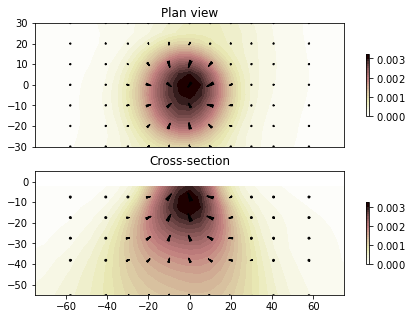

In [20]:
plt.figure(figsize(8, 5))
ax3 = plt.subplot(211)
#PF.Magnetics.plotModelSections
plotModelSections(
    mesh, mrec_C, normal='z', ind=midz-3, subFact=2, 
    scale=0.02, xlim=[-75, 75], ylim=[-30, 30],
    title='Plan view', axs=ax3, vmin=0, vmax=0.0025)
#im,CS = Utils.PlotUtils.plotModelSections(mesh, m, normal='z', ind=-3, subFact=2, scale=0.25, xlim=[-75, 75], ylim=[-30, 30],title="True Model", axs=ax3, vmin=0, vmax=0.065)
ax3.xaxis.set_visible(False)

ax2 = plt.subplot(212)
#PF.Magnetics.plotModelSections
plotModelSections(
    mesh, mrec_C, normal='y', ind=midy, subFact=2, 
    scale=0.02, xlim=[-75, 75], ylim=[-55, 5], 
    axs=ax2, vmin=0, vmax=0.0025,
    title='Cross-section')
#im,CS = Utils.PlotUtils.plotModelSections(mesh, m, normal='y', ind=midy, subFact=2, scale=0.25, xlim=[-75, 75], ylim=[-55, 5],axs=ax2, vmin=0, vmax=0.065)

# Magnetic Vector Inversion - Spherical

In [28]:
mstart = Utils.matutils.xyz2atp(mrec_C.reshape((nC, 3), order='F'))

dmis.prob.coordinate_system = 'spherical'
dmis.prob.model = mstart

# Create a block diagonal regularization
wires = Maps.Wires(('amp', nC), ('theta', nC), ('phi', nC))

# Create a Combo Regularization
# Regularize the amplitude of the vectors
reg_a = Regularization.Sparse(mesh, indActive=actv,
                              mapping=wires.amp)
reg_a.norms = np.c_[0., 0., 0., 0.]  # Sparse on the model and its gradients
reg_a.mref = np.zeros(3*nC)

# Regularize the vertical angle of the vectors
reg_t = Regularization.Sparse(mesh, indActive=actv,
                              mapping=wires.theta)
reg_t.alpha_s = 0.  # No reference angle
reg_t.space = 'spherical'
reg_t.norms = np.c_[2., 0., 0., 0.]  # Only norm on gradients used

# Regularize the horizontal angle of the vectors
reg_p = Regularization.Sparse(mesh, indActive=actv,
                              mapping=wires.phi)
reg_p.alpha_s = 0.  # No reference angle
reg_p.space = 'spherical'
reg_p.norms = np.c_[2., 0., 0., 0.]  # Only norm on gradients used

reg = reg_a + reg_t + reg_p
reg.mref = np.zeros(3*nC)

Lbound = np.kron(np.asarray([0, -np.inf, -np.inf]), np.ones(nC))
Ubound = np.kron(np.asarray([10, np.inf, np.inf]), np.ones(nC))

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=40,
                                 lower=Lbound,
                                 upper=Ubound,
                                 maxIterLS=30,
                                 maxIterCG=30,
                                 tolCG=1e-3,
                                 stepOffBoundsFact=1e-3,
                                 )
opt.approxHinv = None

invProb = InvProblem.BaseInvProblem(dmis, reg, opt, beta=beta)

# Here is where the norms are applied
IRLS = Directives.Update_IRLS(f_min_change=1e-4, maxIRLSiter=40,
                              minGNiter=1, beta_tol=0.5,
                              coolingRate=1.0, coolEps_q=True,
                              betaSearch=False)

# Special directive specific to the mag amplitude problem. The sensitivity
# weights are update between each iteration.
ProjSpherical = Directives.ProjSpherical()
update_SensWeight = Directives.UpdateSensitivityWeights()
update_Jacobi = Directives.UpdatePreconditioner()

inv = Inversion.BaseInversion(
    invProb,
    directiveList=[
        ProjSpherical, IRLS, update_SensWeight, update_Jacobi
    ]
)

mrec_MVI_S = inv.run(mstart)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.41e+07  2.73e+02  1.20e-04  4.37e+03    2.29e+02      0              
   1  1.70e+07  4.13e+02  1.06e-04  2.23e+03    8.10e+02      1              
   2  8.52e+06  4.19e+02  1.05e-04  1.31e+03    8.24e+02      4              
   3  4.26e+06  3.87e+02  1.03e-04  8.28e+02    8.37e+02      3              
   4  2.13e+06  3.72e+02  1.01e-04  5.88e+02    8.40e+02      3              
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 0.0028946698193050902 eps_q: 0.0028946698193050902
eps_p: 1.3771470981144585 eps_q: 1.3771470981144585
eps_p: 6.266738916163419 eps_q: 6.2667389161

KeyboardInterrupt: 

(<matplotlib.axes._subplots.AxesSubplot at 0x21c90aaf748>,
 <matplotlib.colorbar.Colorbar at 0x21c90d18c18>)

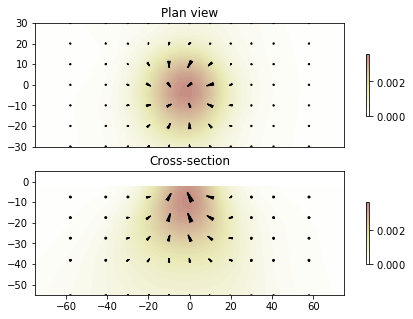

In [29]:
vec_xyz = Utils.matutils.atp2xyz(
    invProb.model.reshape((nC, 3), order='F'))

plt.figure(figsize(8, 5))
ax3 = plt.subplot(211)
#PF.Magnetics.plotModelSections
plotModelSections(
    mesh, vec_xyz, normal='z', ind=midz-3, subFact=2, 
    scale=0.02, xlim=[-75, 75], ylim=[-30, 30],
    title='Plan view', axs=ax3, vmin=0, vmax=0.005)
#im,CS = Utils.PlotUtils.plotModelSections(mesh, m, normal='z', ind=-3, subFact=2, scale=0.25, xlim=[-75, 75], ylim=[-30, 30],title="True Model", axs=ax3, vmin=0, vmax=0.065)
ax3.xaxis.set_visible(False)

ax2 = plt.subplot(212)
#PF.Magnetics.plotModelSections
plotModelSections(
    mesh, vec_xyz, normal='y', ind=midy, subFact=2, 
    scale=0.02, xlim=[-75, 75], ylim=[-55, 5], 
    axs=ax2, vmin=0, vmax=0.005, title='Cross-section')
#im,CS = Utils.PlotUtils.plotModelSections(mesh, m, normal='y', ind=midy, subFact=2, scale=0.25, xlim=[-75, 75], ylim=[-55, 5],axs=ax2, vmin=0, vmax=0.065)

Text(0.5, 1.0, 'Predicted Data')

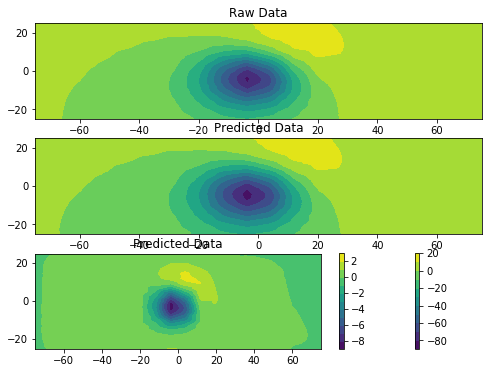

In [18]:
fig = plt.figure(figsize=(8, 6))
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)
out = Utils.plot2Ddata(rxLoc, d, ax=ax1)
ax1.set_title('Raw Data')

out = Utils.plot2Ddata(rxLoc, invProb.dpred, ax=ax2)
ax2.set_title('Predicted Data')
plt.colorbar(out[0])

out = Utils.plot2Ddata(rxLoc, d-invProb.dpred, ax=ax3)
plt.colorbar(out[0])
ax3.set_title('Predicted Data')